# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [150]:
import importlib
import BitcoinModeler

import importlib
importlib.reload(BitcoinModeler)

from BitcoinModeler import *


# Bitcoin Price Prediction

This notebook trains simple linear models for BTC price horizons **H1** and **H7**, evaluates them on **Train/Validation/Test**, plots performance


## 🧱 Data & Splits

We load preprocessed CSVs for both horizons:

- **Train**: used to fit model parameters  
- **Validation (val)**: used to choose models/hyperparameters (no peeking at Test)  
- **Test**: used once at the end for an unbiased performance estimate




In [151]:
# Load h1 data
h1_train = pd.read_csv('data/processed/h1_train.csv')
h1_val = pd.read_csv('data/processed/h1_val.csv')
h1_test = pd.read_csv('data/processed/h1_test.csv')

# Load h7 data
h7_train = pd.read_csv('data/processed/h7_vif_train.csv')
h7_val = pd.read_csv('data/processed/h7_vif_val.csv')
h7_test = pd.read_csv('data/processed/h7_vif_test.csv')

print(f"H1 - Train: {h1_train.shape}, Val: {h1_val.shape}, Test: {h1_test.shape}")
print(f"H7 - Train: {h7_train.shape}, Val: {h7_val.shape}, Test: {h7_test.shape}")

H1 - Train: (1877, 71), Val: (402, 71), Test: (403, 71)
H7 - Train: (1873, 45), Val: (401, 45), Test: (402, 45)


In [152]:
bundle_h1=BitcoinModeler.DataManager.prepare(h1_train, h1_val, h1_test, "y_btc_close_t+1","H1")
bundle_h7=BitcoinModeler.DataManager.prepare(h7_train, h7_val, h7_test, "y_btc_close_t+7","H7")

> Note: Features are **already z-score normalized using train-only stats** in `split.py` to avoid leakage.

In [153]:
# optional if you want to compare scaled vs unscaled 
#scaler_h1_cls = ScalerManager()
#bundle_h1_scaled = scaler_h1_cls.scale_bundle(bundle_h1)

#scaler_h7_cls = ScalerManager()
#bundle_h7_scaled = scaler_h7_cls.scale_bundle(bundle_h7)
#print("Class-based DataBundle objects created (both raw and scaled variants).")


## 🚀 Model Runs

We fit all three models on **H1 (1-hour)** and **H7 (7-day)** horizons, then print per-split metrics.


In [159]:
# === Run experiments
importlib.reload(BitcoinModeler)
runner_h1 = BitcoinModeler.ExperimentRunner(bundle_h1, scaled=True)
df_h1 = runner_h1.run()

runner_h7 = BitcoinModeler.ExperimentRunner(bundle_h7, scaled=True)
df_h7 = runner_h7.run()





Bundle:  H1 Spline columns (selected): ['btc_close', 'btc_roll_mean_close_7', 'btc_ema12', 'btc_ema26']
Bundle:  H1 Passthrough features     : 65
Bundle:  H1 Best params: {'pre__spl__n_knots': 6, 'ridge__alpha': np.float64(100.0)} | Val MSE: 532.5787433069362
Bundle:  H7 Spline columns (selected): ['btc_atr14', 'btc_macd', 'btc_roll_std_close_7', 'btc_rsi14']
Bundle:  H7 Passthrough features     : 39
Bundle:  H7 Best params: {'pre__spl__n_knots': 6, 'ridge__alpha': np.float64(100.0)} | Val MSE: 3349.721895532356


## 📊 Results Table (All Models × Splits)


In [155]:

# Merge all for a single summary table 
results_df_classes = pd.concat([df_h1, df_h7], ignore_index=True)
print("\n——— CLASS-BASED RESULTS SUMMARY ———")
print(results_df_classes.to_string(index=False, float_format="%.6f"))


——— CLASS-BASED RESULTS SUMMARY ———
Horizon Scaled?               Model    Dataset            MSE        RMSE         MAE       R2
     H1     Yes              Linear Validation     386.460641   19.658602   12.094807 0.983038
     H1     Yes              Linear       Test  235784.524346  485.576487  245.162722 0.988930
     H1     Yes               Ridge Validation     560.397341   23.672713   15.585227 0.975404
     H1     Yes               Ridge       Test  301181.604841  548.800150  281.239009 0.985860
     H1     Yes               Lasso Validation     375.775904   19.384940   11.561632 0.983507
     H1     Yes               Lasso       Test  214931.363047  463.606906  235.702833 0.989909
     H1     Yes B Spline with Ridge Validation     532.578743   23.077668   12.865464 0.976625
     H1     Yes B Spline with Ridge       Test  648307.744098  805.175598  467.033100 0.969562
     H7     Yes              Linear Validation    9089.640787   95.339608   68.337234 0.602516
     H7     Y

In [156]:


# Feature importance for Lasso models

lasso_h1 = [m for m in runner_h1.models if m.name == "Lasso"][0]
lasso_h7 = [m for m in runner_h7.models if m.name == "Lasso"][0]
H1ModelWrap=ModelWrapper("H1",lasso_h1.model)
H7ModelWrap=ModelWrapper("H7",lasso_h7.model)



## 📈 Lasso Performance — Validation vs Test

The chart below compares **Nonzero** vs **Zero**  for each horizon (H1, H7).  



Feature Importance Analysis


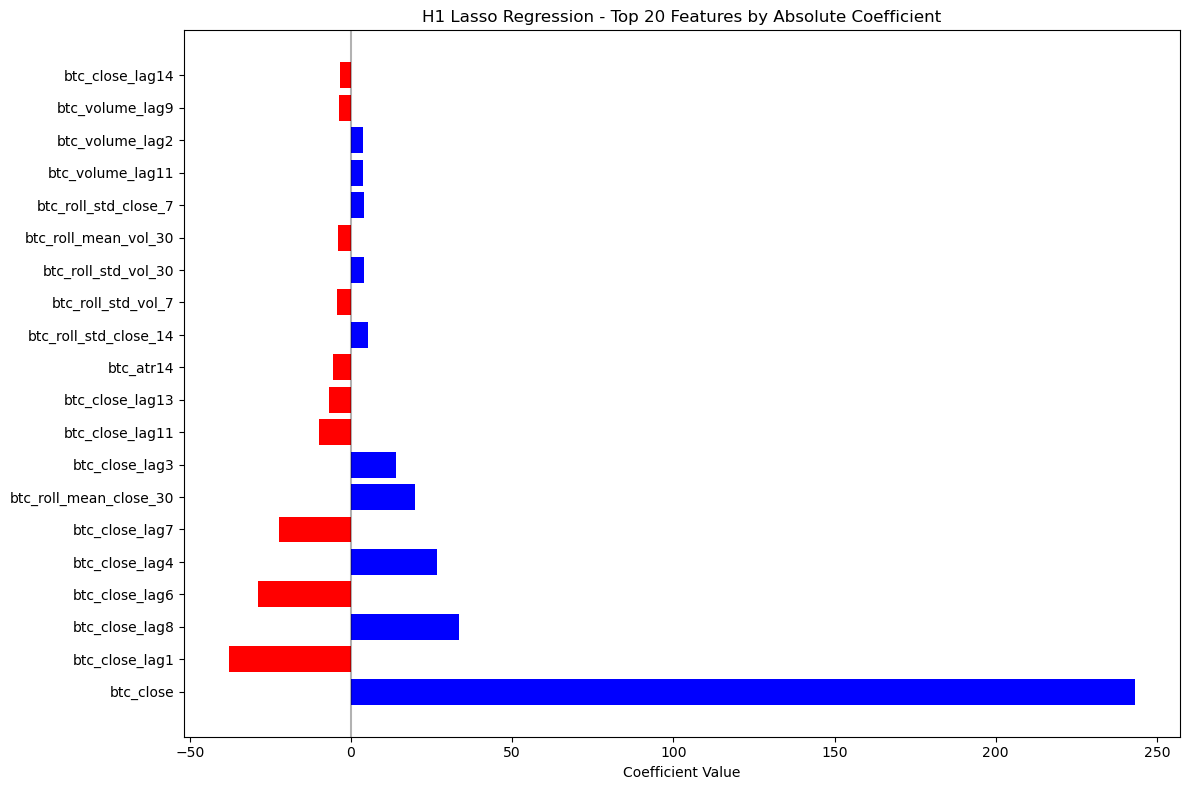

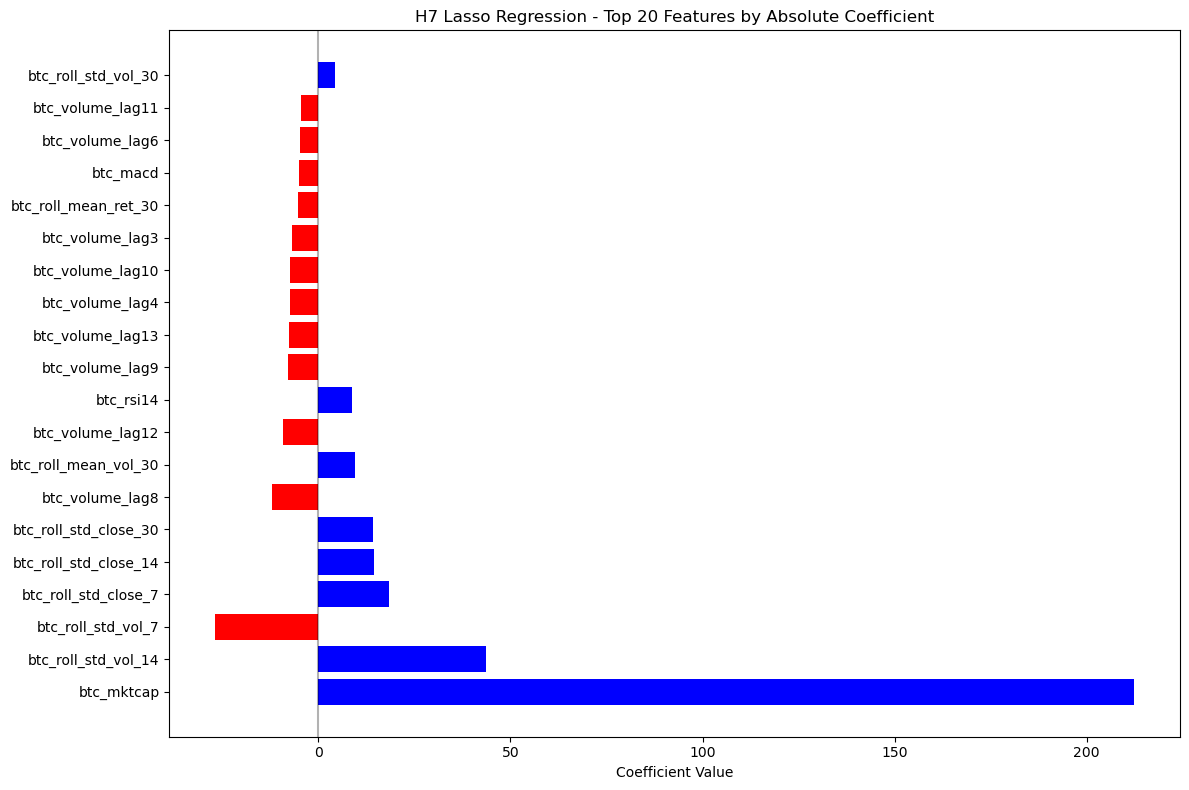

In [157]:
print("Feature Importance Analysis")
print("="*50)
# H1 Lasso
h1_lasso_features = H1ModelWrap.plot_feature_importance(bundle_h1.feature_cols, 'H1 Lasso Regression')
# H7 Lasso  
h7_lasso_features = H7ModelWrap.plot_feature_importance(bundle_h7.feature_cols, 'H7 Lasso Regression')

## 🏆 Best Model Summary (Chosen by Validation RMSE)

For **each horizon**, we pick the model  with the **lowest Validation RMSE**, then report its **R2** and **Test_MSE** metrics.  



In [158]:
# -- Produce and print the best-model summary (pick by Validation RMSE; show Test metrics)
best_summary = ModelWrapper.best_summary(results_df_classes, metric="RMSE", prefer_scaled=None)
print("\n" + "="*80)
print("BEST MODEL SUMMARY — picked by lowest Validation RMSE; Test metrics shown")
print("="*80)
print(best_summary.to_string(index=False, float_format="%.6f"))
print("\n" + "="*80)
print("BEST MODEL SUMMARY — picked by lowest Validation R2; Test metrics shown")
print("="*80)
best_summaryR2 = ModelWrapper.best_summary(results_df_classes, metric="R2", prefer_scaled=None)
print(best_summaryR2.to_string(index=False, float_format="%.6f"))

H1LassoNonZeroCoef=H1ModelWrap.get_lasso_nonzero_coef(bundle_h1.feature_cols)
H7LassoNonZeroCoef=H7ModelWrap.get_lasso_nonzero_coef(bundle_h1.feature_cols)
result = (
    f"H1: {H1LassoNonZeroCoef}/{len(bundle_h1.feature_cols)} features selected | "
    f"H7: {H7LassoNonZeroCoef}/{len(bundle_h7.feature_cols)} features selected"
)
print("Lasso results: ",result)




BEST MODEL SUMMARY — picked by lowest Validation RMSE; Test metrics shown
Horizon               Model Scaled?  Val_RMSE            MSE        RMSE        MAE       R2
     H1               Lasso     Yes 19.384940  214931.363047  463.606906 235.702833 0.989909
     H7 B Spline with Ridge     Yes 57.876782 1923721.580489 1386.982906 756.489549 0.909718

BEST MODEL SUMMARY — picked by lowest Validation R2; Test metrics shown
Horizon               Model Scaled?   Val_R2            MSE        RMSE        MAE       R2
     H1               Lasso     Yes 0.983507  214931.363047  463.606906 235.702833 0.989909
     H7 B Spline with Ridge     Yes 0.853519 1923721.580489 1386.982906 756.489549 0.909718
Lasso results:  H1: 53/69 features selected | H7: 43/43 features selected


## 🧭 Baselines & Diagnostics 
  1. Compare model performance across different prediction timeframes
  2. Regularization effects of Ridge vs Lasso regression
  3. Feature selection capabilities of Lasso regression
  4. Model stability across validation and test sets
